In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import boxcox
from scipy.stats import norm
from scipy.stats import probplot
from statsmodels.api import qqplot

import random

from tqdm import tqdm

In [45]:
RND_STATE = 777

In [73]:
datasets_names = ["Тренировочный", "Валидационный", "Контрольный"]
datasets_path = ["Train_wo_na.csv", "Valid_wo_na.csv", "Control_wo_na.csv"]

train = pd.read_csv(fr'Data\{datasets_path[0]}', encoding='cp1251', index_col = 0)
valid = pd.read_csv(fr'Data\{datasets_path[1]}', encoding='cp1251', index_col = 0)
test = pd.read_csv(fr'Data\{datasets_path[2]}', encoding='cp1251', index_col = 0)

datasets = [train, valid, test]

# Нормализация распределения количественных переменных

В отличие от линейной регрессии, логистическая регрессия не полагается на предположение о нормальном распределении. Однако, решение может стать более стабильным, если распределение предикторов будет многомерным нормальным.

Для этого можно применить преобразование Бокса-Кокса для количественных столбцов.

Однако, стоит помнить, что **$\lambda$ берется с обучающих данных и с ее помощью преобразуются тестовые и контрольные данные**.

In [74]:
quant_cols = train.dtypes[(train.dtypes == int) | (train.dtypes == float)].index

Преобразование Бокса-Кокса требует от данных положительного знака.
$$y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$$

$$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda - 1}{\lambda};\text{если } \lambda \neq 0,\\ \log{(y_i)}; \text{если } \lambda = 0.\end{cases}$$ 
Можно посмотреть, в каких предикторах у нас имеются отрицательные значения.

In [75]:
(train[quant_cols] <= 0).sum()

age                          0
credit_sum                   0
score_shk                    1
monthly_income               0
credit_count             24604
overdue_credit_count    114368
dtype: int64

In [76]:
for col in ['score_shk', 'credit_count', 'overdue_credit_count']:
    print(f'{col} {train[train[col] <= 0][col].unique()}')

score_shk [0.]
credit_count [ 0. -1.]
overdue_credit_count [ 0. -1.]


Таким образом, в колонке `score_shk` у нас присутствует одно значение равное 0, в колонках `credit_count` и `overdue_credit_count` есть два значения, 0 - нет кредитов данной категории, а -1 означает, что нет информации по данной переменной. Можно прибавить к данным колонкам 0.0001 и 1.0001 соответственно.

Также можно добавить колонки, отражающие наличие пропусков в `credit_count` и `overdue_credit_count`, далее мы все равно проведем дамми-кодирование новых переменных.

In [77]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col + '_na'] = np.where((df[col] == -1), 1, 0).astype('object')

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.00it/s]


In [79]:
for col in tqdm(['credit_count', 'overdue_credit_count']):
    for df in datasets:
        df[col] = df[col] + 1.0001
        
for df in datasets:
    df['score_shk'] = df['score_shk'] + 0.0001

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 334.10it/s]


In [80]:
(train[quant_cols] <= 0).sum()
# Теперь у нас нет отрицательных и нулевых значений

age                     0
credit_sum              0
score_shk               0
monthly_income          0
credit_count            0
overdue_credit_count    0
dtype: int64

In [81]:
quant_cols =['age', 'credit_sum', 'monthly_income',
             'credit_count', 'overdue_credit_count', 'score_shk']

Lambda for age: -0.314
Lambda for credit_sum: 0.041
Lambda for monthly_income: -0.143
Lambda for credit_count: 0.520
Lambda for overdue_credit_count: 0.933
Lambda for score_shk: 0.647


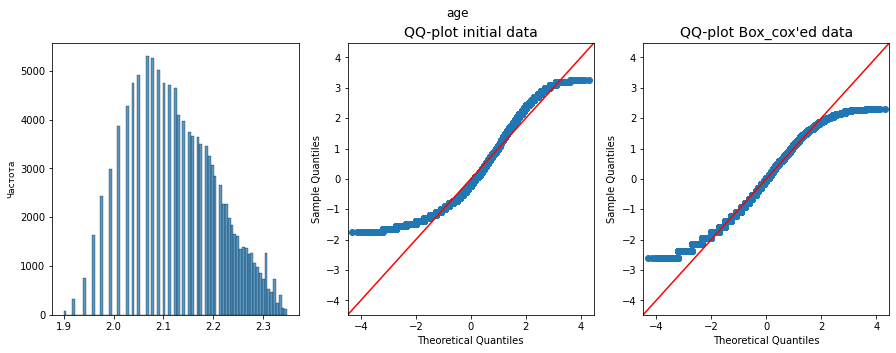

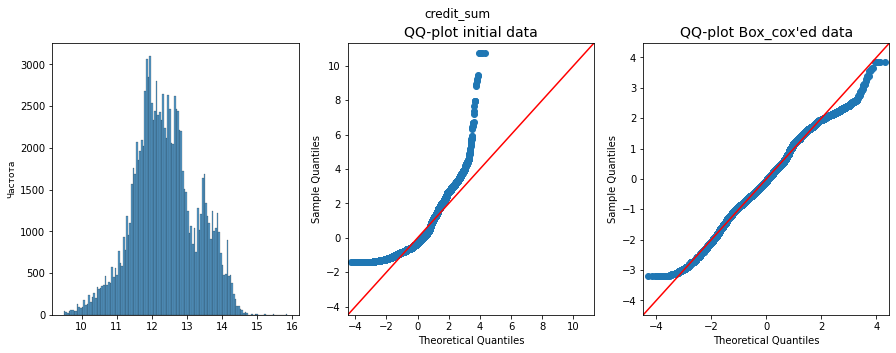

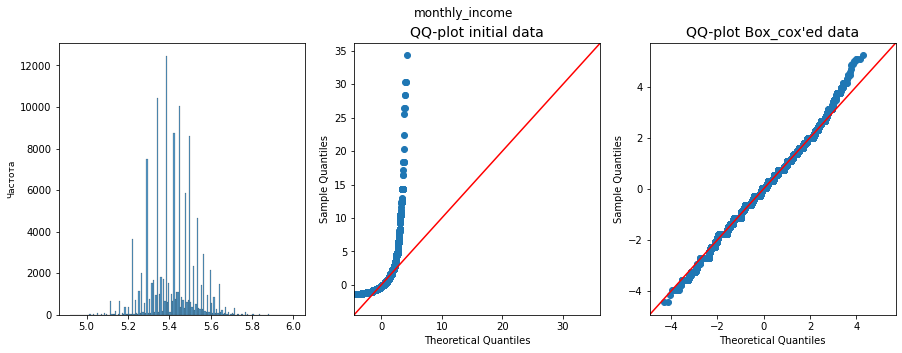

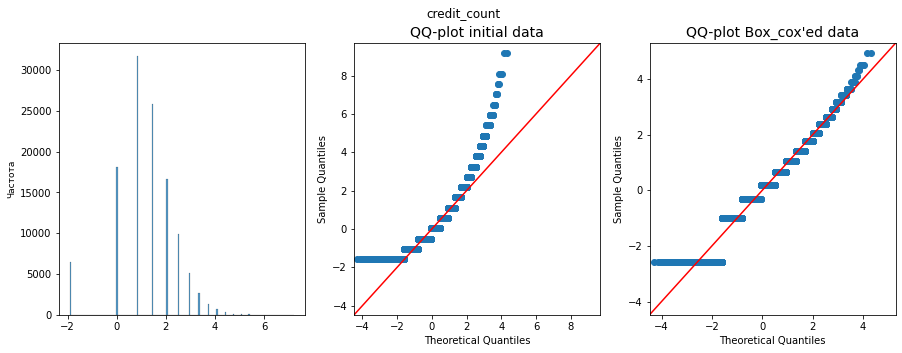

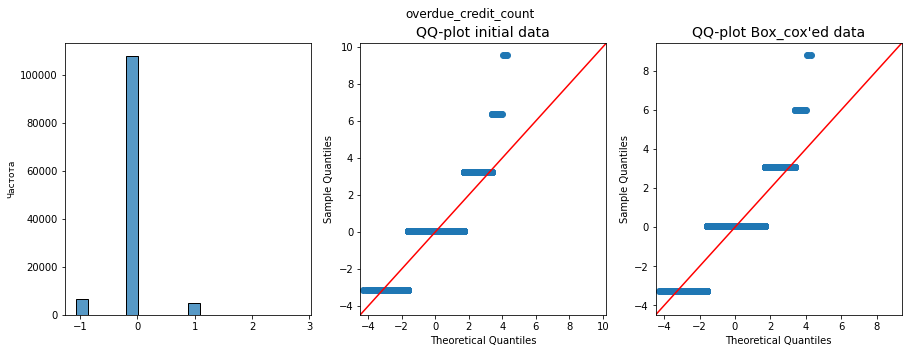

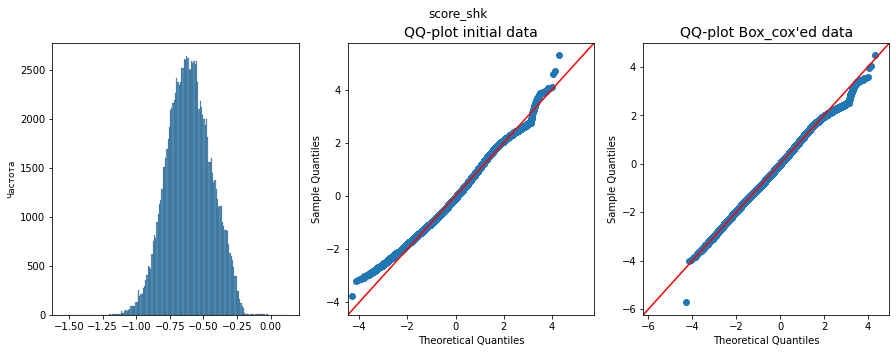

In [82]:
for col in quant_cols:
    transformed, lam = boxcox(train[col])
    print(f'Lambda for {col}: {lam:.3f}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    sns.histplot(transformed, ax=ax[0])
    qqplot(train[col], norm, fit=True, line='45', ax=ax[1])
    qqplot(transformed, norm, fit=True, line='45', ax=ax[2])

    ax[0].set_ylabel('Частота', fontsize=9)
    ax[1].set_title("QQ-plot initial data", fontsize=14)
    ax[2].set_title("QQ-plot Box_cox'ed data", fontsize=14)
    fig.suptitle(col)

Можно заметить, что преобразование Бокса-Кокса не обязательно для `credit_count`, `overdue_credit_count`, `score_shk`, поскольку не приводит к значимому улучшению вида распределения переменной. Таким образом, нам надо преобразовать колонки `age`, `credit_sum`, `monthly_income`. Во избежание нулевых значений в тестовом и контрольных наборах до преобразования прибавим к ним 0.0001.

In [83]:
transformation_lambdas = {}
for col in tqdm(['age', 'credit_sum', 'monthly_income']):
    for ind, df in enumerate(datasets):
        df[col] = df[col] + 0.0001
        if ind == 0:
# Поскольку у нас тренировочный датасет первый в списке
            df[col], lam = boxcox(df[col])    
            transformation_lambdas[col] = lam
        else:
            df[col]= boxcox(df[col], lam)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


In [84]:
transformation_lambdas

{'age': -0.3141984713191933,
 'credit_sum': 0.041243837642655067,
 'monthly_income': -0.1432669670943293}